## Memebers
1. Faizan Karamat
2. Nibtahil Nafees
3. Abdul Wasay

## Method: Color Histogram Comparison

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plotImg(img):
    if (len(img.shape) == 2):
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.axis('off')
    plt.show()

def plot_patches(patches, max_cols=5):
    num_patches = len(patches)
    num_rows = (num_patches + max_cols - 1) // max_cols  # Calculate the number of rows needed
    fig, axes = plt.subplots(num_rows, max_cols, figsize=(10*max_cols, 10*num_rows))

    for i, patch in enumerate(patches):
        row = i // max_cols
        col = i % max_cols
        patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)  # Convert patch to RGB
        axes[row, col].imshow(patch_rgb, interpolation='nearest')
        axes[row, col].axis('off')

    # Hide empty subplots
    for i in range(num_patches, num_rows * max_cols):
        row = i // max_cols
        col = i % max_cols
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
def get_patches(img, patch_size):
    height, width = img.shape[:2]
    patch_height, patch_width = patch_size

    patches = []
    
    for y in range(0, height - patch_height + 1, patch_height):
        for x in range(0, width - patch_width + 1, patch_width):
            patch = img[y: y + patch_height, x : x + patch_width].copy()  # Make a copy to avoid modifying the original image
            patches.append(patch)

    max_cols = img.shape[1] // patch_width
    
    return max_cols, np.array(patches)

## Graph construction

In [4]:
import networkx as nx

### Helper functions

In [5]:
def color_hist(patch, bins=256):
    hist_b = cv2.calcHist(patch, [0], None, [bins], [0,256])
    hist_g = cv2.calcHist(patch, [1], None, [bins], [0,256])
    hist_r = cv2.calcHist(patch, [2], None, [bins], [0,256])

    concat_hist = cv2.hconcat([hist_b, hist_g, hist_r])

    cv2.normalize(concat_hist, concat_hist, alpha=0, beta= 1, norm_type=cv2.NORM_MINMAX)

    return concat_hist

In [6]:
def plot_histograms(hist1, hist2, bins=20):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(hist1[:, 0], color='b', label='Blue')
    plt.plot(hist1[:, 1], color='g', label='Green')
    plt.plot(hist1[:, 2], color='r', label='Red')
    plt.title('Histogram of Image 1')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(hist2[:, 0], color='b', label='Blue')
    plt.plot(hist2[:, 1], color='g', label='Green')
    plt.plot(hist2[:, 2], color='r', label='Red')
    plt.title('Histogram of Image 2')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
class PatchGraph:
    def __init__(self, img):
        self.graph = nx.Graph()
        self.nodes = self.graph.nodes
        self.edges = self.graph.edges
        self.img = img
        
    def add_patch(self, patch, patch_id):
        self.graph.add_node(patch_id, patch=patch)
        
    def add_similarity(self, patch_id1, patch_id2, similarity):
        self.graph.add_edge(patch_id1, patch_id2, similarity=similarity)

    def get_patches(self):
        return [self.graph.nodes[patch_id]['patch'] for patch_id in self.graph.nodes]

    def print_similarity(self, patch_id1, patch_id2):
        if self.graph.has_edge(patch_id1, patch_id2):
            similarity = self.graph[patch_id1][patch_id2]['similarity']
            print(f"Similarity between Patch {patch_id1} and Patch {patch_id2}: {similarity}")
        else:
            print(f"No similarity information available for Patch {patch_id1} and Patch {patch_id2}")

    def get_graph(self):
        return self.graph

### Adding edges based on similarity score
1. Used intersection method to get the similarity score
2. Applied threshold to only add edge in similar patches

In [8]:
def create_graph(img, patch_size , bins=32, threshold=0.5) -> PatchGraph:
    max_cols, patches = get_patches(img, patch_size)
    # Initialize graph
    patch_graph = PatchGraph(img)

    # Add nodes
    for i, patch in enumerate(patches):
        patch_graph.add_patch(patch, i)

    # Add edges based on color histogram intersection
    for i in range(len(patches)):
        hist1 = color_hist(patches[i], bins)
        
        for j in range(len(patches)):
            if i==j:
                continue
            
            hist2 = color_hist(patches[j], bins)
            score = 1 - cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)
    
            ## Add edge if greater than the threshold
            if score > threshold:
                patch_graph.add_similarity(i, j, score)
    
    return patch_graph

In [9]:
img1 = cv2.imread("./porsche911_1.jpg")
img2 = cv2.imread("./porsche911_2.jpg")
img3 = cv2.imread("./porsche911-3.png")
img4 = cv2.imread("./kabo-p6yH8VmGqxo-unsplash.jpg")
img5 = cv2.imread("./raoul-droog-yMSecCHsIBc-unsplash.jpg")
img6 = cv2.imread("./nature-3082832_1920.jpg")

img1 = cv2.resize(img1, (1920, 1080))
img2 = cv2.resize(img2, (1920, 1080))
img3 = cv2.resize(img3, (1920, 1080))
img4 = cv2.resize(img4, (1920, 1080))
img5 = cv2.resize(img5, (1920, 1080))
img6 = cv2.resize(img6, (1920, 1080))

In [10]:
patch_size = (128, 128)
pg1 = create_graph(img1, patch_size)
pg2 = create_graph(img2, patch_size)
pg3 = create_graph(img3, patch_size)
pg4 = create_graph(img4, patch_size)
pg5 = create_graph(img5, patch_size)
pg6 = create_graph(img6, patch_size)

## Graph Matching

In [11]:
print(f"Graph\t\tNodes\tEdges")
print(f"Graph 1\t\t{pg1.graph.number_of_nodes()}\t{pg1.graph.number_of_edges()}")
print(f"Graph 2\t\t{pg2.graph.number_of_nodes()}\t{pg2.graph.number_of_edges()}")
print(f"Graph 3\t\t{pg3.graph.number_of_nodes()}\t{pg3.graph.number_of_edges()}")
print(f"Graph 4\t\t{pg4.graph.number_of_nodes()}\t{pg4.graph.number_of_edges()}")
print(f"Graph 5\t\t{pg5.graph.number_of_nodes()}\t{pg5.graph.number_of_edges()}")
print(f"Graph 6\t\t{pg6.graph.number_of_nodes()}\t{pg6.graph.number_of_edges()}")

Graph		Nodes	Edges
Graph 1		120	737
Graph 2		120	652
Graph 3		120	1072
Graph 4		120	1387
Graph 5		120	1504
Graph 6		120	1410


In [12]:
def ged(graph1: PatchGraph, graph2: PatchGraph, graph3: PatchGraph, graph4: PatchGraph):
    print(f"Graph 1 -> {graph1.edges}", end='\n\n\n')
    print(f"Graph 2 -> {graph2.edges}", end='\n\n\n')
    print(f"Graph 3 -> {graph3.edges}", end='\n\n\n')
    print(f"Graph 4 -> {graph4.edges}", end='\n\n\n')

In [13]:
g1 = pg1.get_graph()
g2 = pg2.get_graph()
g3 = pg3.get_graph()
g4 = pg4.get_graph()
g5 = pg5.get_graph()
g6 = pg6.get_graph()

In [38]:
def GED(graph1, graph2, cost_insertion=1, cost_deletion=1, cost_substitution=1):
    nodes1, edges1 = graph1.nodes, graph1.edges
    nodes2, edges2 = graph2.nodes, graph2.edges
    
    # Initialize cost matrix
    rows = len(nodes1)
    cols = len(nodes2)
    cost_matrix = np.zeros((rows, cols))
    
    # Compute edge differences
    total_ops = 0
    edge_diff = 0
    for edge1 in edges1:
        total_ops += 1 
        if edge1 not in edges2: ## Insertion cost
            edge_diff += 0 #graph1.get_edge_data(edge1[0], edge1[1])['similarity']
        else:                   ## Subsitution cost
            edge_diff += 1 - abs(graph1.get_edge_data(edge1[0], edge1[1])['similarity'] - graph2.get_edge_data(edge1[0], edge1[1])['similarity'])

    for edge2 in edges2:
        if edge2 not in edges1:    ## Deletion cost
            edge_diff += 0 #graph2.get_edge_data(edge2[0], edge2[1])['similarity']
            total_ops += 0

    return (edge_diff / total_ops)

In [39]:
GED(g1, g1), GED(g1, g2), GED(g1,g6), GED(g4, g5), GED(g1, g4)

(1.0,
 0.1637108147123489,
 0.30561453005864797,
 0.23495741932848746,
 0.25463018959218137)

In [16]:
def plot_images_with_similarity(img1, img2):
    img1 = cv2.resize(img1, (1920, 1080))
    img2 = cv2.resize(img2, (1920, 1080))
    
    patch_size = (64, 64)
    pg1 = create_graph(img1, patch_size)
    pg2 = create_graph(img2, patch_size)

    g1 = pg1.get_graph()
    g2 = pg2.get_graph()

    similarity_score = GED(g1, g2)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot first image
    axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image 1')

    # Plot second image
    axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Image 2')

    # Display similarity score
    plt.suptitle(f'Similarity Score: {similarity_score:.4f}', fontsize=14)
    # Hide axes
    for ax in axes:
        ax.axis('off')

    plt.show()

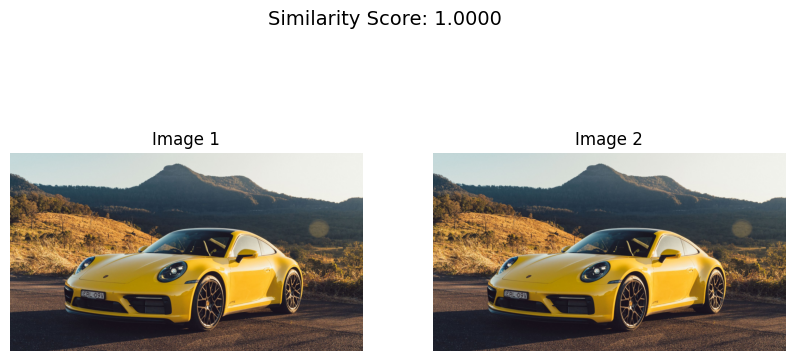

In [17]:
plot_images_with_similarity(img1, img1)

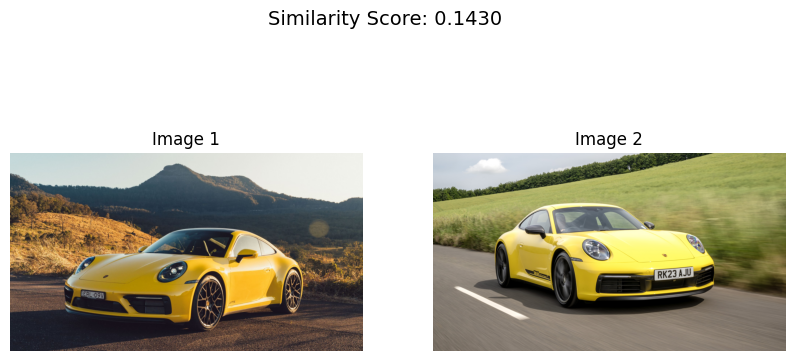

In [18]:
plot_images_with_similarity(img1, img2)

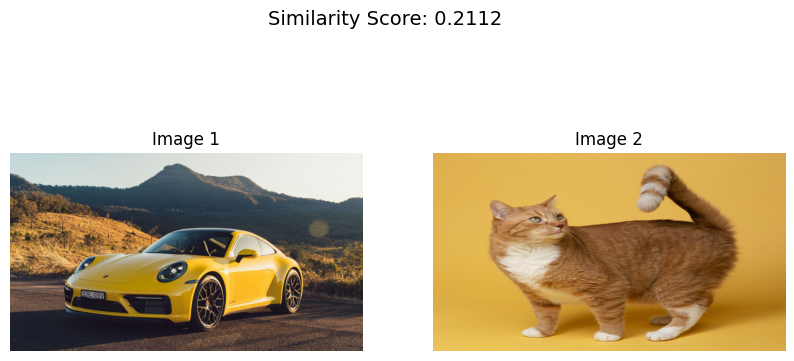

In [19]:
plot_images_with_similarity(img1, img4)

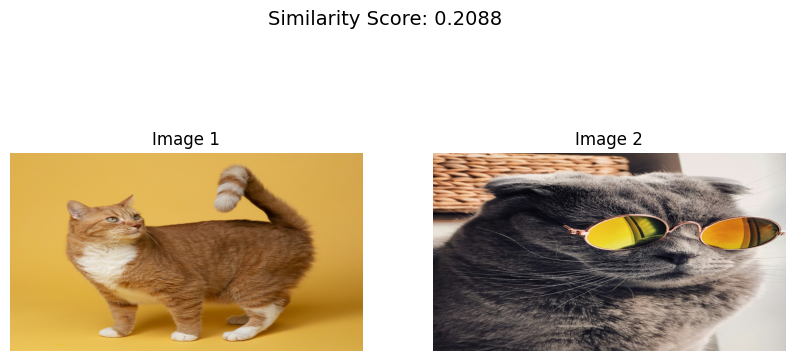

In [20]:
plot_images_with_similarity(img4, img5)

## Metrics

In [21]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio as psnr

In [22]:
def issm_score(image1, image2):
  if image1.shape != image2.shape:
    raise ValueError("Images must have the same shape.")

  image1_fft = np.fft.fft2(image1)
  image2_fft = np.fft.fft2(image2)

  # Calculate the phase spectrum
  phase1 = np.angle(image1_fft)
  phase2 = np.angle(image2_fft)

  # Calculate the ISSM score
  issm = np.mean(np.abs(np.sin(phase1 - phase2)))

  return issm

In [23]:
def get_metrics(img1, img2):
    gray_image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Compute SSIM
    ssim_score = ssim(gray_image1, gray_image2)
    
    # Compute RMSE
    rmse_score = mean_squared_error(gray_image1, gray_image2)
    
    # Compute PSNR
    psnr_score = psnr(gray_image1, gray_image2)

    # Compute ISSM
    issm_score_ = issm_score(img1, img2)
    
    similarity_metrics = {
            "ssim": ssim_score,
            "rmse": rmse_score,
            "psnr_score": psnr_score,
            "issm_score": issm_score_
    }

    return similarity_metrics

In [25]:
images = [img1, img2, img3, img4, img5]

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        similarity_metrics = get_metrics(images[i], images[j])
        print(f"============== Image {i + 1} to Image {j + 1} Metrics ==============")
        for metric, value in similarity_metrics.items():
            print(f"{metric.capitalize()}\t{value:.4f}")
        print("\n\n")

============== Image 1 to Image 2 Metrics ==============
Ssim	0.3435
Rmse	7665.3860
Psnr_score	9.2855
Issm_score	0.6347



============== Image 1 to Image 3 Metrics ==============
Ssim	0.2885
Rmse	9495.2203
Psnr_score	8.3558
Issm_score	0.6282



============== Image 1 to Image 4 Metrics ==============
Ssim	0.3582
Rmse	7982.7372
Psnr_score	9.1093
Issm_score	0.6359



============== Image 1 to Image 5 Metrics ==============
Ssim	0.1736
Rmse	8205.2744
Psnr_score	8.9899
Issm_score	0.6200



============== Image 2 to Image 3 Metrics ==============
Ssim	0.3351
Rmse	9234.9051
Psnr_score	8.4765
Issm_score	0.6360



============== Image 2 to Image 4 Metrics ==============
Ssim	0.4731
Rmse	5313.8029
Psnr_score	10.8767
Issm_score	0.6364



============== Image 2 to Image 5 Metrics ==============
Ssim	0.1920
Rmse	8813.7885
Psnr_score	8.6792
Issm_score	0.6352



============== Image 3 to Image 4 Metrics ==============
Ssim	0.3165
Rmse	10677.1391
Psnr_score	7.8463
Issm_score	0.6362



==============